# Compare floating and fixed

In [1]:
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 # '/ccs/proj/cfd162/lcheung/amr-wind-frontend.lcc/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/'
                ]
import sys, os, shutil, io
import numpy as np
for x in amrwindfedirs: sys.path.insert(1, x)

from functools import partial
import matplotlib.pyplot as plt

# Make all plots inline 
%matplotlib inline

import postproengine as ppeng	

In [2]:
# Load ruamel or pyyaml as needed
try:
    import ruamel.yaml
    yaml = ruamel.yaml.YAML(typ='unsafe', pure=True)
    useruamel=True
    loaderkwargs = {'Loader':yaml.RoundTripLoader}
    dumperkwargs = {'Dumper':yaml.RoundTripDumper, 'indent':4, 'default_flow_style':False}
    Loader=yaml.load
except:
    import yaml as yaml
    useruamel=False
    loaderkwargs = {}
    dumperkwargs = {'default_flow_style':False }
    Loader=yaml.safe_load

In [3]:
def HH_XD(XD):
    x0 = 1200
    y0 = 500
    D  = 240
    L  = 1.5
    dX = 2
    ptlist = [[x0+XD*D, y+y0] for y in np.arange(-L*D, L*D+0.001, dX)]
    return ptlist

def XZ():
    x0 = 1200
    x  = 4
    D  = 240
    ptlist = [[x0+x*D, 0, z] for z in np.arange(6,450)]
    return ptlist

def XZ_XD(x):
    x0 = 1200
    D  = 240
    ptlist = [[x0+x*D, 0, z] for z in np.arange(6,450)]
    return ptlist
    
for x in [4,6,8,10, 12]:
    funcname = 'XZ_%iD'%(x)
    setattr(ppeng, funcname, partial(XZ_XD, x))
    funcname = 'HH_%iD'%(x)
    setattr(ppeng, funcname, partial(HH_XD, x))
    

ppeng.XZfunc = XZ

In [4]:
yamlstring="""

tavg: &tavg [27550, 28450] #[27550, 28150]

globalattributes:
  verbose: False
#  udfmodules:
#  - testinterp.py  
  executeorder:
  - avgworkflowXZ
  - avgworkflowXY
  - plotcsv
#  - instantaneousplanes

interpstuff: &interpstuff
  name: stuff
  pointlocationfunction: postproengine.XZ_8D
  pointcoordsystem:     XYZ
  varnames: ['velocityx_avg', 'velocityy_avg', 'velocityz_avg']
  iplane: 0
  savefile: floating_XZ.dat

interpXY: &interpXY
  name: stuff
  pointlocationfunction: postproengine.HH_8D
  pointcoordsystem:     A1A2
  varnames: ['velocityx_avg', 'velocityy_avg', 'velocityz_avg']
  iplane: 0
  savefile: floating_XY.dat 

avgworkflowXZ:
  avgplanes:
  - name: avg_fixed
    ncfile:
    - /lustre/orion/cfd162/world-shared/lcheung/AdvancedControlsWakes/Runs/MedWS_LowTI.Frontier/oneturb_4x2/Baseline/MedWS_LowTI_4kmx2km_5m/post_processing/XZ_68125.nc
    - /lustre/orion/cfd162/world-shared/lcheung/AdvancedControlsWakes/Runs/MedWS_LowTI.Frontier/oneturb_4x2/Baseline/MedWS_LowTI_4kmx2km_5m/post_processing/XZ_103125.nc
    tavg: *tavg
    #savepklfile:  fixed_avg_XZplane.pkl         # Name of pickle file to save results (Optional, Default: '')
    loadpklfile:  fixed_avg_XZplane.pkl 
    #group: T0_YZ_wake2              # Which group to pull from netcdf file (Optional, Default: None)
    contourplot:
      plotfunc: "lambda db: np.sqrt(db['velocityx_avg']**2 + db['velocityy_avg']**2)"
      clevels: 'np.linspace(0, 12, 121)'
      title: 'AVG horizontal velocity (Fixed)'
      xaxis: x           # Which axis to use on the abscissa 
      yaxis: z           # Which axis to use on the ordinate 
      iplane: [0]
      ylabel: Z/D
      xlabel: X/D
      cbar_nticks: 7
      xscalefunc: "lambda x: (x-1200)/240"
      yscalefunc: "lambda y: (y-150)/240"
    interpolate:
    - <<: *interpstuff
      pointlocationfunction: postproengine.XZ_4D
      savefile: fixed_XZ_4D.dat    
    - <<: *interpstuff
      pointlocationfunction: postproengine.XZ_6D
      savefile: fixed_XZ_6D.dat
    - <<: *interpstuff
      pointlocationfunction: postproengine.XZ_8D
      savefile: fixed_XZ_8D.dat
    - <<: *interpstuff
      pointlocationfunction: postproengine.XZ_10D
      savefile: fixed_XZ_10D.dat
      
      #name: stuff
      #pointlocationfunction: postproengine.XZ_8D
      #pointcoordsystem:     XYZ
      #varnames: ['velocityx_avg', 'velocityy_avg', 'velocityz_avg']
      #iplane: 0
      #savefile: fixed_XZ.dat

  - name: avg_floating
    ncfile:
    - /lustre/orion/cfd162/world-shared/lcheung/ALCC_Frontier_WindFarm/floating/MedWS_LowTI/oneturb_4x2/MedWS_LowTI_Jonswap_baseline/post_processing/XZ_*.nc
    tavg: *tavg
    #savepklfile:  floating_avg_XZplane.pkl         # Name of pickle file to save results (Optional, Default: '')
    loadpklfile:  floating_avg_XZplane.pkl
    #group: T0_YZ_wake2              # Which group to pull from netcdf file (Optional, Default: None)
    contourplot:
      plotfunc: "lambda db: np.sqrt(db['velocityx_avg']**2 + db['velocityy_avg']**2)"
      clevels: 'np.linspace(0, 12, 121)'
      title: 'AVG horizontal velocity (Floating)'
      xaxis: x           # Which axis to use on the abscissa 
      yaxis: z           # Which axis to use on the ordinate 
      iplane: [0]
      ylabel: Z/D
      xlabel: X/D
      cbar_nticks: 7
      xscalefunc: "lambda x: (x-1200)/240"
      yscalefunc: "lambda y: (y-150)/240"

    interpolate:
    - <<: *interpstuff
      pointlocationfunction: postproengine.XZ_4D
      savefile: floating_XZ_4D.dat    
    - <<: *interpstuff
      pointlocationfunction: postproengine.XZ_6D
      savefile: floating_XZ_6D.dat
    - <<: *interpstuff
      pointlocationfunction: postproengine.XZ_8D
      savefile: floating_XZ_8D.dat
    - <<: *interpstuff
      pointlocationfunction: postproengine.XZ_10D
      savefile: floating_XZ_10D.dat

#      name: stuff
#      pointlocationfunction: postproengine.XZ_8D
#      pointcoordsystem:     XYZ
#      varnames: ['velocityx_avg', 'velocityy_avg', 'velocityz_avg']
#      iplane: 0
#      savefile: floating_XZ.dat

avgworkflowXY:
  avgplanes:
  - name: avg_fixed
    ncfile:
    - /lustre/orion/cfd162/world-shared/lcheung/AdvancedControlsWakes/Runs/MedWS_LowTI.Frontier/oneturb_4x2/Baseline/MedWS_LowTI_4kmx2km_5m/post_processing/XY_*.nc
    tavg: *tavg
    #savepklfile:  fixed_avg_XYplane.pkl        # Name of pickle file to save results (Optional, Default: '')
    loadpklfile:  fixed_avg_XYplane.pkl
    #group: T0_YZ_wake2              # Which group to pull from netcdf file (Optional, Default: None)
    contourplot:
      plotfunc: "lambda db: np.sqrt(db['velocityx_avg']**2 + db['velocityy_avg']**2)"
      title: 'AVG horizontal velocity (Fixed)'
      xaxis: x           # Which axis to use on the abscissa 
      yaxis: y           # Which axis to use on the ordinate 
      iplane: [1]
    interpolate:
    - <<: *interpXY
      pointlocationfunction: postproengine.HH_4D
      savefile: fixed_XY_4D.dat
    - <<: *interpXY
      pointlocationfunction: postproengine.HH_6D
      savefile: fixed_XY_6D.dat
    - <<: *interpXY
      pointlocationfunction: postproengine.HH_8D
      savefile: fixed_XY_8D.dat
    - <<: *interpXY
      pointlocationfunction: postproengine.HH_10D
      savefile: fixed_XY_10D.dat
  - name: avg_floating
    ncfile:
    - /lustre/orion/cfd162/world-shared/lcheung/ALCC_Frontier_WindFarm/floating/MedWS_LowTI/oneturb_4x2/MedWS_LowTI_Jonswap_baseline/post_processing/XY_*.nc
    tavg: *tavg
    #savepklfile:  floating_avg_XYplane.pkl         # Name of pickle file to save results (Optional, Default: '')
    loadpklfile:  floating_avg_XYplane.pkl
    #group: T0_YZ_wake2              # Which group to pull from netcdf file (Optional, Default: None)
    contourplot:
      plotfunc: "lambda db: np.sqrt(db['velocityx_avg']**2 + db['velocityy_avg']**2)"
      title: 'AVG horizontal velocity (Floating)'
      xaxis: x           # Which axis to use on the abscissa 
      yaxis: y           # Which axis to use on the ordinate 
      iplane: [1]
    interpolate:
    - <<: *interpXY
      pointlocationfunction: postproengine.HH_4D
      savefile: floating_XY_4D.dat
    - <<: *interpXY
      pointlocationfunction: postproengine.HH_6D
      savefile: floating_XY_6D.dat
    - <<: *interpXY
      pointlocationfunction: postproengine.HH_8D
      savefile: floating_XY_8D.dat    
    - <<: *interpXY
      pointlocationfunction: postproengine.HH_10D
      savefile: floating_XY_10D.dat
      
instantaneousplanes:
  - name: Fixed XY
    ncfile: /lustre/orion/cfd162/world-shared/lcheung/AdvancedControlsWakes/Runs/MedWS_LowTI.Frontier/oneturb_4x2/Baseline/MedWS_LowTI_4kmx2km_5m/post_processing/XY_103125.nc
    iters:  [-1]
    iplane: 1
    xaxis: x
    yaxis: y
    # --- optional stuff here ---
    plot:
      title: 'Fixed turbine velocity T={time:0.2f}'
      plotfunc: "lambda db,i: np.sqrt(db['velocityx'][i]**2 + db['velocityy'][i]**2)"
      clevels: 'np.linspace(0, 12, 121)'
      xlabel: 'X [m]'
      ylabel: 'Y [m]'
      cbar_nticks: 13
  - name: Floating XY
    ncfile: /lustre/orion/cfd162/world-shared/lcheung/ALCC_Frontier_WindFarm/floating/MedWS_LowTI/oneturb_4x2/MedWS_LowTI_Jonswap_baseline/post_processing/XY_68125.nc
    iters:  [-1]
    iplane: 1
    xaxis: x
    yaxis: y
    # --- optional stuff here ---
    plot:
      title: 'Floating turbine velocity T={time:0.2f}'
      plotfunc: "lambda db,i: np.sqrt(db['velocityx'][i]**2 + db['velocityy'][i]**2)"
      clevels: 'np.linspace(0, 12, 121)'
      xlabel: 'X [m]'
      ylabel: 'Y [m]'
      cbar_nticks: 13

  - name: Fixed XZ
    ncfile: /lustre/orion/cfd162/world-shared/lcheung/AdvancedControlsWakes/Runs/MedWS_LowTI.Frontier/oneturb_4x2/Baseline/MedWS_LowTI_4kmx2km_5m/post_processing/XZ_103125.nc
    iters:  [-1]
    iplane: 0
    xaxis: x
    yaxis: z
    # --- optional stuff here ---
    plot:
      title: 'Fixed turbine velocity T={time:0.2f}'
      plotfunc: "lambda db,i: np.sqrt(db['velocityx'][i]**2 + db['velocityy'][i]**2)"
      clevels: 'np.linspace(0, 12, 121)'
      xlabel: 'X [m]'
      ylabel: 'Z [m]'
      cbar_nticks: 7
  - name: Floating XZ
    ncfile: /lustre/orion/cfd162/world-shared/lcheung/ALCC_Frontier_WindFarm/floating/MedWS_LowTI/oneturb_4x2/MedWS_LowTI_Jonswap_baseline/post_processing/XZ_68125.nc
    iters:  [-1]
    iplane: 0
    xaxis: x
    yaxis: z
    # --- optional stuff here ---
    plot:
      title: 'Floating turbine velocity T={time:0.2f}'
      plotfunc: "lambda db,i: np.sqrt(db['velocityx'][i]**2 + db['velocityy'][i]**2)"
      clevels: 'np.linspace(0, 12, 121)'
      xlabel: 'X [m]'
      ylabel: 'Z [m]'
      cbar_nticks: 7

# --------- PLOT 2D LINE DATA ---------------------
plotcsv:
  - name: plotCL
    #ylabel: 'Z [m]'
    xlabel: '$U$'
    title: 'x/D = 4'
    figsize: [3,4]
    legendopts: {'loc':'upper left'}
    figname: XZplot
    axesnum: 0
    csvfiles:
    - {'file':'fixed_XZ_4D.dat', 'xcol':'velocityx_avg', 'ycol':'z', 'lineopts':{'lw':1, 'label':'Fixed'},
       'xscalefunc':'lambda u:u/9.0', 'yscalefunc':'lambda z:z' }
    - {'file':'floating_XZ_4D.dat', 'xcol':'velocityx_avg', 'ycol':'z', 'lineopts':{'lw':1, 'label':'Floating'},
       'xscalefunc':'lambda u:u/9.0', 'yscalefunc':'lambda z:z'}
  - name: plotCL
    #ylabel: 'Z [m]'
    xlabel: '$U$'
    title: 'x/D = 6'
    figsize: [3,4]
    legendopts: {'loc':'upper left'}
    figname: XZplot
    axesnum: 1
    csvfiles:
    - {'file':'fixed_XZ_6D.dat', 'xcol':'velocityx_avg', 'ycol':'z', 'lineopts':{'lw':1, 'label':'Fixed'},
       'xscalefunc':'lambda u:u/9.0', 'yscalefunc':'lambda z:z' }
    - {'file':'floating_XZ_6D.dat', 'xcol':'velocityx_avg', 'ycol':'z', 'lineopts':{'lw':1, 'label':'Floating'},
       'xscalefunc':'lambda u:u/9.0', 'yscalefunc':'lambda z:z'}
  - name: plotCL
    #ylabel: 'Z [m]'
    xlabel: '$U$'
    title: 'x/D = 8'
    figsize: [3,4]
    legendopts: {'loc':'upper left'}
    figname: XZplot
    axesnum: 2
    csvfiles:
    - {'file':'fixed_XZ_8D.dat', 'xcol':'velocityx_avg', 'ycol':'z', 'lineopts':{'lw':1, 'label':'Fixed'},
       'xscalefunc':'lambda u:u/9.0', 'yscalefunc':'lambda z:z' }
    - {'file':'floating_XZ_8D.dat', 'xcol':'velocityx_avg', 'ycol':'z', 'lineopts':{'lw':1, 'label':'Floating'},
       'xscalefunc':'lambda u:u/9.0', 'yscalefunc':'lambda z:z'}
  - name: plotCL
    #ylabel: 'Z [m]'
    xlabel: '$U$'
    title: 'x/D = 10'
    figsize: [3,4]
    legendopts: {'loc':'upper left'}
    figname: XZplot
    axesnum: 3
    csvfiles:
    - {'file':'fixed_XZ_10D.dat', 'xcol':'velocityx_avg', 'ycol':'z', 'lineopts':{'lw':1, 'label':'Fixed'},
       'xscalefunc':'lambda u:u/9.0', 'yscalefunc':'lambda z:z' }
    - {'file':'floating_XZ_10D.dat', 'xcol':'velocityx_avg', 'ycol':'z', 'lineopts':{'lw':1, 'label':'Floating'},
       'xscalefunc':'lambda u:u/9.0', 'yscalefunc':'lambda z:z'}

  - name: plotXY
    ylabel: 'Y/D'
    xlabel: '$U$'
    title: 'x/D = 4'
    legendopts: {'loc':'upper left'}
    figname: XYplot
    axesnum: 0
    csvfiles:
    - {'file':'fixed_XY_4D.dat', 'xcol':'velocityx_avg', 'ycol':'y', 'lineopts':{'lw':1, 'label':'Fixed'},
       'xscalefunc':'lambda u:u/9.0', 'yscalefunc':'lambda y:(y-1000)/240' }
    - {'file':'floating_XY_4D.dat', 'xcol':'velocityx_avg', 'ycol':'y', 'lineopts':{'lw':1, 'label':'Floating'},
       'xscalefunc':'lambda u:u/9.0', 'yscalefunc':'lambda y:(y-1000)/240'}
  - name: plotXY
    #ylabel: 'Y/D'
    xlabel: '$U$'
    title: 'x/D = 6'
    legendopts: {'loc':'upper left'}
    figname: XYplot
    axesnum: 1
    csvfiles:
    - {'file':'fixed_XY_6D.dat', 'xcol':'velocityx_avg', 'ycol':'y', 'lineopts':{'lw':1, 'label':'Fixed'},
       'xscalefunc':'lambda u:u/9.0', 'yscalefunc':'lambda y:(y-1000)/240' }
    - {'file':'floating_XY_6D.dat', 'xcol':'velocityx_avg', 'ycol':'y', 'lineopts':{'lw':1, 'label':'Floating'},
       'xscalefunc':'lambda u:u/9.0', 'yscalefunc':'lambda y:(y-1000)/240'}
  - name: plotXY
    #ylabel: 'Y/D'
    xlabel: '$U$'
    title: 'x/D = 8'
    legendopts: {'loc':'upper left'}
    figname: XYplot
    axesnum: 2
    csvfiles:
    - {'file':'fixed_XY_8D.dat', 'xcol':'velocityx_avg', 'ycol':'y', 'lineopts':{'lw':1, 'label':'Fixed'},
       'xscalefunc':'lambda u:u/9.0', 'yscalefunc':'lambda y:(y-1000)/240' }
    - {'file':'floating_XY_8D.dat', 'xcol':'velocityx_avg', 'ycol':'y', 'lineopts':{'lw':1, 'label':'Floating'},
       'xscalefunc':'lambda u:u/9.0', 'yscalefunc':'lambda y:(y-1000)/240'}
  - name: plotXY
    #ylabel: 'Y/D'
    xlabel: '$U$'
    title: 'x/D = 10'
    legendopts: {'loc':'upper left'}
    figname: XYplot
    axesnum: 3
    csvfiles:
    - {'file':'fixed_XY_10D.dat', 'xcol':'velocityx_avg', 'ycol':'y', 'lineopts':{'lw':1, 'label':'Fixed'},
       'xscalefunc':'lambda u:u/9.0', 'yscalefunc':'lambda y:(y-1000)/240' }
    - {'file':'floating_XY_10D.dat', 'xcol':'velocityx_avg', 'ycol':'y', 'lineopts':{'lw':1, 'label':'Floating'},
       'xscalefunc':'lambda u:u/9.0', 'yscalefunc':'lambda y:(y-1000)/240'}
"""
f = io.StringIO(yamlstring)
yamldict = Loader(f, **loaderkwargs)

Initialized avgplanes
Running avgplanes
Initialized contourplot inside avgplanes
Executing contourplot
Initialized interpolate inside avgplanes
Executing interpolate
Initialized contourplot inside avgplanes
Executing contourplot
Initialized interpolate inside avgplanes
Executing interpolate
Initialized avgplanes
Running avgplanes
Initialized contourplot inside avgplanes
Executing contourplot
Initialized interpolate inside avgplanes
Executing interpolate
Initialized contourplot inside avgplanes
Executing contourplot
Initialized interpolate inside avgplanes
Executing interpolate
Initialized plotcsv
Running plotcsv


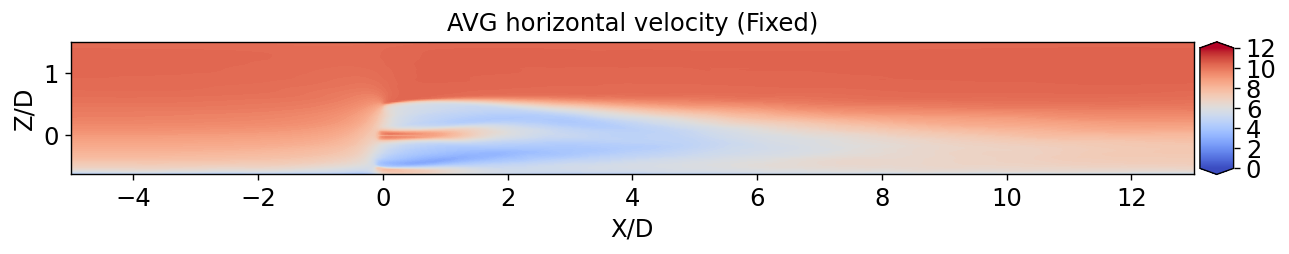

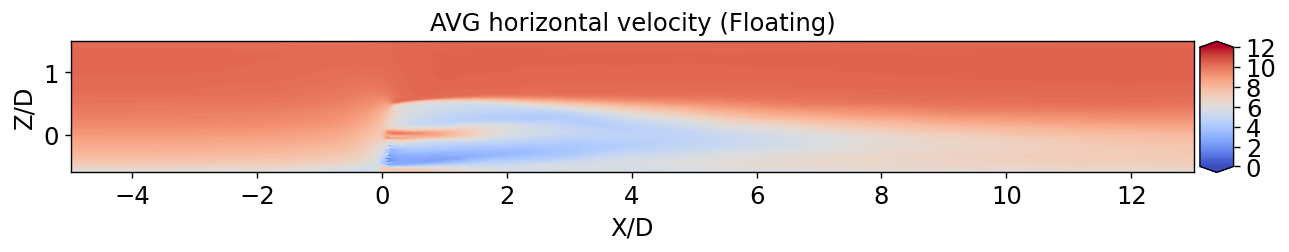

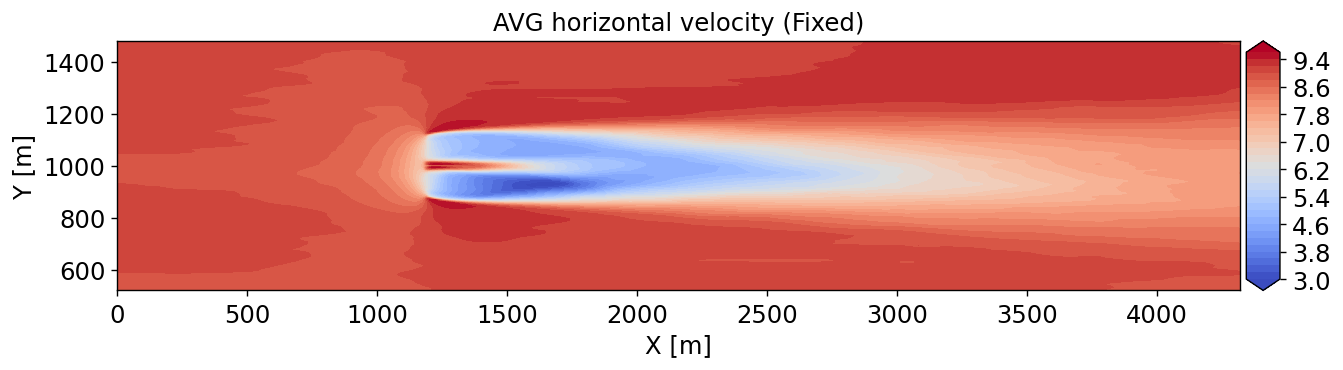

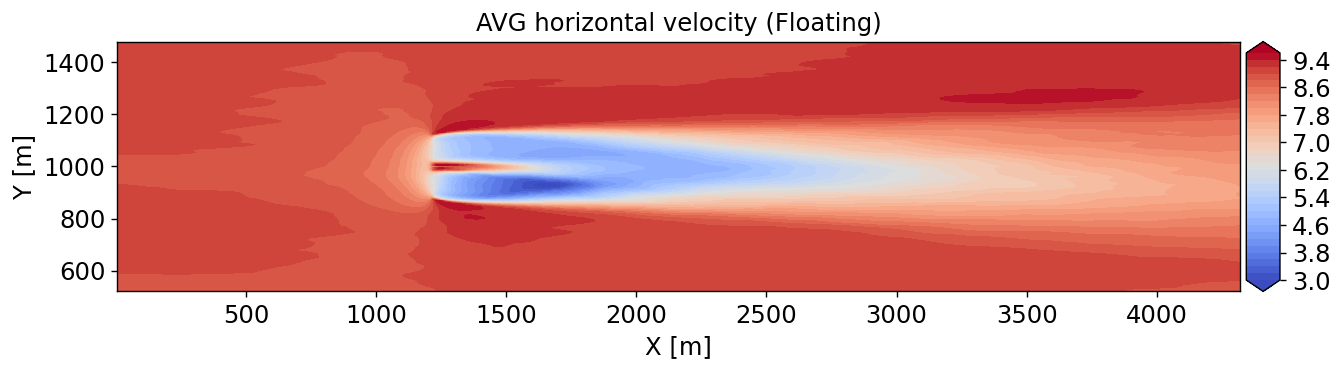

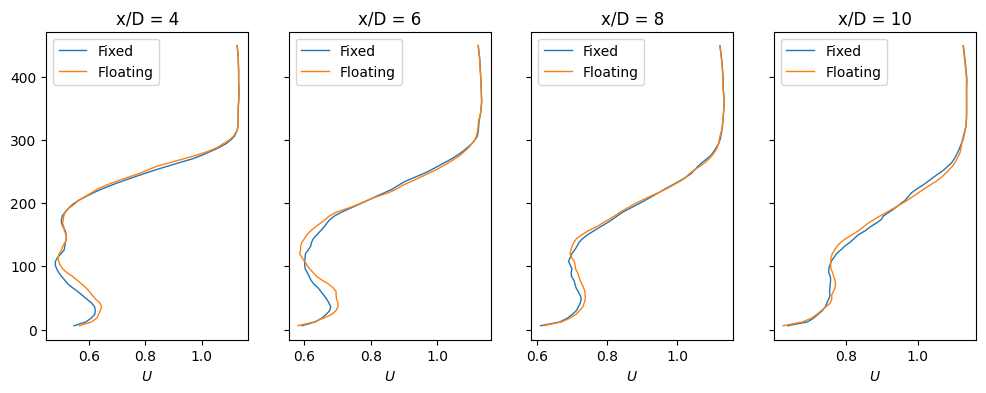

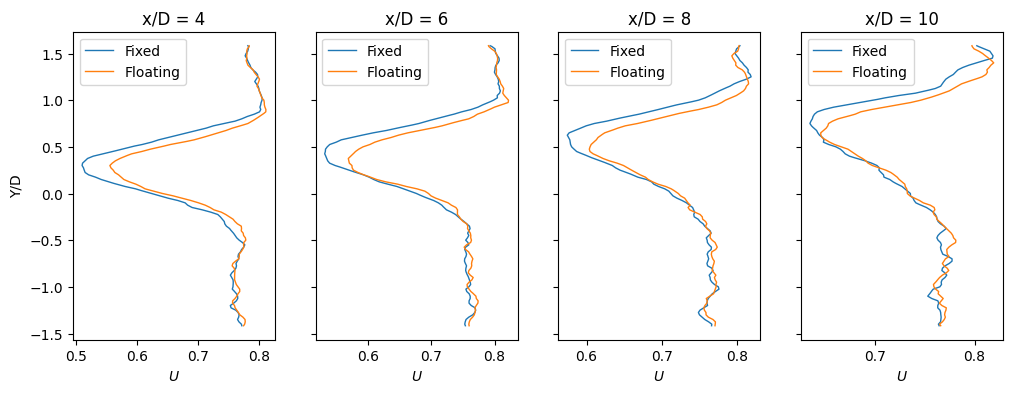

In [5]:
# Run the driver
fig, axs = plt.subplots(1,4, figsize=(12,4), num="XYplot", sharey=True)
fig, axs = plt.subplots(1,4, figsize=(12,4), num="XZplot", sharey=True)
ppeng.driver(yamldict, verbose=True)